In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats
from scipy.spatial.distance import cdist

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns

from awear_function_lib import load_eeg_data, apply_filters, plot_psd, plot_ratios_bar, calculate_ratios
from awear_function_lib import plot_spectrogram, plot_band_ratios_spectrogram, plot_band_ratios_box_whisker, plot_band_ratio_heatmap, plot_avg_power_heatmap
from awear_function_lib import remove_outliers, compute_time_resolved_pac, compute_effect_sizes
from awear_function_lib import compute_sample_entropy, compute_approximate_entropy, compute_average_entropy, compute_anova_entropy, compute_pairwise_tests

import itertools
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

import importlib
import awear_function_lib
importlib.reload(awear_function_lib) 

In [ ]:
def compute_pac_analysis(data,freq_range1,freq_range2,participant,band_names,fs=200,num_bins=18):
    """
    Computes Phase-Amplitude Coupling (PAC) for an *ENTIRE* dataset across emotional states
    
    Parameters:
    - data: Dictionary containing EEG data for each emotional state
    - fs: Sampling frequency (default 200 Hz)
    - freq_range1: Tuple specifying band range 
    - freq_range2: Tuple specifying band range 
    - num_bins: Number of bins for phase-amplitude coupling (default 18)

    Returns:
    - PAC heatmap plot
    - DataFrame of PAC values for each state
    """
    def compute_power_phase(filtered_data):
        """
        Computes the instantaneous power and phase using the Hilbert Transform
        """
        power_phase_data = {}
        for state, signal_data in filtered_data.items():
            analytic_signal = signal.hilbert(signal_data)
            signal_power, signal_phase = np.abs(analytic_signal)**2, np.angle(analytic_signal)
            power_phase_data[state] = [signal_power, signal_phase]
        return power_phase_data

    def compute_pac(band_phase1, band_amplitude2, num_bins):
        """
        Computes the Modulation Index (MI) using phase binning and KL divergence
        """
        bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)
        bin_indices = np.digitize(band_phase1, bin_edges) - 1

        mean_amplitude = np.array([
            band_amplitude2[bin_indices == i].mean() if np.any(bin_indices == i) else 0
            for i in range(num_bins)
        ])

        mean_amplitude = np.where(mean_amplitude > 0, mean_amplitude / mean_amplitude.sum(), 1e-10)

        uniform_dist = np.ones(num_bins) / num_bins
        mi = scipy.stats.entropy(mean_amplitude, uniform_dist)

        return mi

    # Apply bandpass filters
    band_filtered1 = apply_filters(data, bandpass_range=freq_range1,fs=fs)
    band_filtered2 = apply_filters(data, bandpass_range=freq_range2,fs=fs)

    # Compute power and phase
    band_pp1 = compute_power_phase(band_filtered1) # filtered data power and phase information for first frequency band
    band_pp2 = compute_power_phase(band_filtered2) # filtered data power and phase information for second frequency band

    # Compute PAC for each state
    pac_results = {}
    for state in band_pp1.keys():
        band_phase1 = band_pp1[state][1]  # Extract phase
        band_amplitude2 = np.sqrt(band_pp2[state][0])  # Convert power to amplitude
        pac_results[state] = compute_pac(band_phase1, band_amplitude2, num_bins)

    # Convert PAC results into a DataFrame
    pac_df = pd.DataFrame.from_dict(pac_results, orient='index', columns=['PAC Strength'])

    # Plot heatmap
    fig,ax = plt.subplots(figsize=(7,5))
    fig.suptitle(f"{participant}")
    sns.heatmap(pac_df.T, annot=True, cmap="viridis", cbar=True, fmt=".5f")
    ax.set_title(f"Phase-Amplitude Coupling (PAC) - {band_names}")
    ax.set_xlabel("Emotional States")
    plt.show()

    return pac_df

In [ ]:
# Define file paths and labels
file_paths = [
    '.../Subject 3 Antonio/Erotic_5.txt',
    '.../Subject 3 Antonio/Fear 2_1.txt',
    '.../Subject 3 Antonio/Scenery_2.txt',
    '.../Subject 3 Antonio/Sadness_7.txt'
    #'.../Subject 3 Antonio/Neutral_2.txt'
]
labels = [
    "Happy",
    "Tense",
    "Relaxed",
    "Sad"
    #"Neutral"
]

# Load EEG data with correct labels
antonio_data = load_eeg_data(file_paths=file_paths, data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=labels, channel=0)  

# Delta/Beta (50,110)
# Delta/Gamma (62,122)
# Theta/Beta (50,110)
# Theta/Gamma (50,110)
# Alpha/Beta (50,110)
# Alpha/Gamma (35,95), (44,104)

antonio_ht = load_eeg_data(file_paths=file_paths[:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=labels, channel=0)  
antonio_hr = load_eeg_data(file_paths=file_paths[0:3:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=["Happy","Relaxed"], channel=0)  



print(antonio_data["Relaxed"].shape)
print(antonio_data["Tense"].shape)
#print(antonio_data["Neutral"].shape)

# Remove Outliers
antonio_data = remove_outliers(antonio_data)
antonio_ht = remove_outliers(antonio_ht)
antonio_hr = remove_outliers(antonio_hr)


(24000,)
(24000,)


In [ ]:
# Define file paths and labels
file_paths = [
    '.../Subject 5 Ana/Happy_4.txt',
    '.../Subject 5 Ana/Tense_3.txt',
    '.../Subject 5 Ana/Relaxed_4.txt',
    '.../Subject 5 Ana/Sad_5.txt'
    #'.../Subject 5 Ana/Neutral_2.txt'
]

labels = [
    "Happy",
    "Tense",
    "Relaxed",
    "Sad"
    #"Neutral"
]

# Load EEG data with correct labels
ana_data = load_eeg_data(file_paths=file_paths, data_type="openbci", 
                     segments=[(0,120)],  
                     fs=200, labels=labels, channel=0)  

# Delta/Beta (36,96)
# Delta/Gamma (53,113), (38,98)
# Theta/Beta (60,120)
# Theta/Gamma (45,105), (47,107)
# Alpha/Beta (57,117)
# Alpha/Gamma (56,116)

ana_ht = load_eeg_data(file_paths=file_paths[:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=labels, channel=0)  
ana_hr = load_eeg_data(file_paths=file_paths[0:3:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=["Happy","Relaxed"], channel=0)  



print(ana_data["Relaxed"].shape)
print(ana_data["Tense"].shape)
#print(ana_data["Neutral"].shape)

# Remove Outliers
ana_data = remove_outliers(ana_data)
ana_ht = remove_outliers(ana_ht)
ana_hr = remove_outliers(ana_hr)


(24000,)
(24000,)


In [ ]:
# Define file paths and labels
file_paths = [
    '.../Subject 1 Ale/Erotic_3.txt',
    '.../Subject 1 Ale/Fear_2.txt',
    '.../Subject 1 Ale/Scenery_4.txt',
    '.../Subject 1 Ale/Sadness_2.txt'
    #'.../Subject 1 Ale/Neutral_2.txt'

]

labels = [
    "Happy",
    "Tense",
    "Relaxed",
    "Sad"
    #"Neutral"
]

# Load EEG data with correct labels
ale_data = load_eeg_data(file_paths=file_paths, data_type="openbci", 
                     segments=[(0,110)], 
                     fs=200, labels=labels, channel=0)  

# Delta/Beta (51,111)/(54,114)
# Delta/Gamma (30,90)
# Theta/Beta (42,102),(54,114),(48,108)
# Theta/Gamma (8,68),(14,74), (38,98)
# Alpha/Beta (24,84),(22,82)
# Alpha/Gamma (36,96)


ale_ht = load_eeg_data(file_paths=file_paths[:2], data_type="openbci", 
                     segments=[(0,110)], 
                     fs=200, labels=labels, channel=0)  
ale_hr = load_eeg_data(file_paths=file_paths[0:3:2], data_type="openbci", 
                     segments=[(0,110)], 
                     fs=200, labels=["Happy","Relaxed"], channel=0)  

# ale_data2 = load_eeg_data(file_paths=file_paths, data_type="openbci", 
#                      segments=[None], 
#                      fs=200, labels=labels, channel=1)  
# ale_data3 = load_eeg_data(file_paths=file_paths, data_type="openbci", 
#                      segments=[None], 
#                      fs=200, labels=labels, channel=2)  
# ale_data4 = load_eeg_data(file_paths=file_paths, data_type="openbci", 
#                      segments=[None], 
#                      fs=200, labels=labels, channel=3)  



print(ale_data["Relaxed"].shape)
print(ale_data["Tense"].shape)
#print(ale_data["Neutral"].shape)

#fs = 200

# Remove Outliers
ale_data = remove_outliers(ale_data)
ale_ht = remove_outliers(ale_ht)
ale_hr = remove_outliers(ale_hr)

# ale_data = apply_filters(ale_data, fs = 200)

# ale_data2 = remove_outliers(ale_data2)
# ale_data3 = remove_outliers(ale_data3)
# ale_data4 = remove_outliers(ale_data4)

# ale_data2 = apply_filters(ale_data2, fs = 200)
# ale_data3 = apply_filters(ale_data3, fs = 200)
# ale_data4 = apply_filters(ale_data4, fs = 200)

# test = [ale_data["Sad"], ale_data2["Sad"], ale_data3["Sad"], ale_data4["Sad"]]
# fig, ax = plt.subplots(4,1,figsize=(12,6))

# for i,data in enumerate(test):
#     t_vector = np.arange(0,len(data)/fs, 1/fs)
#     ax[i].plot(t_vector,data, label=f"Channel {i}")
#     ax[i].set(xlabel='Time(s)', ylabel='Voltage(uV)')

# plt.tight_layout()
# plt.show()


(22000,)
(22000,)


In [ ]:
# Define file paths and labels
file_paths = [
    '.../Subject 2 Jenny/Erotic_2.txt',
    '.../Subject 2 Jenny/Fear2_2.txt',
    '.../Subject 2 Jenny/Scenery_4.txt',
    '.../Subject 2 Jenny/Sadness_2.txt'
    #'.../Subject 2 Jenny/Neutral_2.txt'
]

labels = [
    "Happy",
    "Tense",
    "Relaxed",
    "Sad"
    #"Neutral"
]

# Load EEG data with correct labels
jenny_data = load_eeg_data(file_paths=file_paths, data_type="openbci", 
                     segments=[(0,120)],   
                     fs=200, labels=labels, channel=0)  

# Delta/Beta (22,82)
# Delta/Gamma (10,70), (40,100)
# Theta/Beta (22,82)
# Theta/Gamma (0,60)
# Alpha/Beta (0,60)
# Alpha/Gamma (0,60)

jenny_ht = load_eeg_data(file_paths=file_paths[:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=labels, channel=0)  
jenny_hr = load_eeg_data(file_paths=file_paths[0:3:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=["Happy","Relaxed"], channel=0)  



print(jenny_data["Relaxed"].shape)
print(jenny_data["Tense"].shape)
#print(jenny_data["Neutral"].shape)

# Remove Outliers
jenny_data = remove_outliers(jenny_data)
jenny_ht = remove_outliers(jenny_ht)
jenny_hr = remove_outliers(jenny_hr)

(22785,)
(24000,)


In [ ]:
# Define file paths and labels
file_paths = [
    '.../Subject 6 Luisa/Happy_0_Meisner.txt',
    '.../Subject 6 Luisa/Tense_0_Meisner.txt',
    '.../Subject 6 Luisa/Relaxed_9.txt',
    '.../Subject 6 Luisa/Sad_0_Maisner.txt'
    #'.../Subject 6 Luisa/Neutral_2.txt'    

]

labels = [
    "Happy",
    "Tense",
    "Relaxed",
    "Sad"
    #"Neutral"
]

# Load EEG data with correct labels
luisa_data = load_eeg_data(file_paths=file_paths, data_type="openbci", 
                     segments=(0,120),  
                     fs=200, labels=labels, channel=0)  

# Delta/Beta (61,121)
# Delta/Gamma (60,120)
# Theta/Beta (61,121)
# Theta/Gamma (59,119)
# Alpha/Beta (36,96),(34,94)
# Alpha/Gamma (51,111)

luisa_ht = load_eeg_data(file_paths=file_paths[:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=labels, channel=0)  
luisa_hr = load_eeg_data(file_paths=file_paths[0:3:2], data_type="openbci", 
                     segments=[(0,120)], 
                     fs=200, labels=["Happy","Relaxed"], channel=0)  


print(luisa_data["Happy"].shape)
print(luisa_data["Tense"].shape)
print(luisa_data["Relaxed"].shape)
print(luisa_data["Sad"].shape)
#print(luisa_data["Neutral"].shape)

# Remove Outliers
luisa_data = remove_outliers(luisa_data)
luisa_ht = remove_outliers(luisa_ht)
luisa_hr = remove_outliers(luisa_hr)


(18883,)
(24000,)
(18036,)
(24000,)


In [6321]:
# # Apply PAC analysis to data --> Delta - Beta
# ana_pac_results = compute_pac_analysis(ana_data,freq_range1=(4,8),freq_range2=(12,30),participant="Ana",band_names="Delta - Beta",num_bins=18)
# antonio_pac_results = compute_pac_analysis(antonio_data,freq_range1=(4,8),freq_range2=(12,30),participant="Antonio",band_names="Delta - Beta",num_bins=18)
# ale_pac_results = compute_pac_analysis(ale_data,freq_range1=(4,8),freq_range2=(12,30),participant="Ale",band_names="Delta - Beta",num_bins=18)
# jenny_pac_results = compute_pac_analysis(jenny_data,freq_range1=(4,8),freq_range2=(12,30),participant="Jenny",band_names="Delta - Beta",num_bins=18)
# luisa_pac_results = compute_pac_analysis(luisa_data,freq_range1=(4,8),freq_range2=(12,30),participant="Luisa",band_names="Delta - Beta",num_bins=18)

In [6322]:
# # Apply PAC analysis to data --> Delta - Gamma
# ana_pac_results = compute_pac_analysis(ana_data,freq_range1=(0.5,4),freq_range2=(30,50),participant="Ana",band_names="Delta-Gamma",num_bins=18)
# antonio_pac_results = compute_pac_analysis(antonio_data,freq_range1=(0.5,4),freq_range2=(30,50),participant="Antonio",band_names="Delta-Gamma",num_bins=18)
# ale_pac_results = compute_pac_analysis(ale_data,freq_range1=(0.5,4),freq_range2=(30,50),participant="Ale",band_names="Delta-Gamma",num_bins=18)
# jenny_pac_results = compute_pac_analysis(jenny_data,freq_range1=(0.5,4),freq_range2=(30,50),participant="Jenny",band_names="Delta-Gamma",num_bins=18)
# luisa_pac_results = compute_pac_analysis(luisa_data,freq_range1=(0.5,4),freq_range2=(30,50),participant="Luisa",band_names="Delta-Gamma",num_bins=18)

In [6323]:
# # Apply PAC analysis to data --> Theta - Beta
# ana_pac_results = compute_pac_analysis(ana_data,freq_range1=(4,8),freq_range2=(12,30),participant="Ana",band_names="Theta - Beta",num_bins=18)
# antonio_pac_results = compute_pac_analysis(antonio_data,freq_range1=(4,8),freq_range2=(12,30),participant="Antonio",band_names="Theta - Beta",num_bins=18)
# ale_pac_results = compute_pac_analysis(ale_data,freq_range1=(4,8),freq_range2=(12,30),participant="Ale",band_names="Theta - Beta",num_bins=18)
# jenny_pac_results = compute_pac_analysis(jenny_data,freq_range1=(4,8),freq_range2=(12,30),participant="Jenny",band_names="Theta - Beta",num_bins=18)
# luisa_pac_results = compute_pac_analysis(luisa_data,freq_range1=(4,8),freq_range2=(12,30),participant="Luisa",band_names="Theta - Beta",num_bins=18)

In [6324]:
# # Apply PAC analysis to data --> Theta - Gamma
# ana_pac_results = compute_pac_analysis(ana_data,freq_range1=(4,8),freq_range2=(30,50),participant="Ana",band_names="Theta-Gamma",num_bins=18)
# antonio_pac_results = compute_pac_analysis(antonio_data,freq_range1=(4,8),freq_range2=(30,50),participant="Antonio",band_names="Theta-Gamma",num_bins=18)
# ale_pac_results = compute_pac_analysis(ale_data,freq_range1=(4,8),freq_range2=(30,50),participant="Ale",band_names="Theta-Gamma",num_bins=18)
# jenny_pac_results = compute_pac_analysis(jenny_data,freq_range1=(4,8),freq_range2=(30,50),participant="Jenny",band_names="Theta-Gamma",num_bins=18)
# luisa_pac_results = compute_pac_analysis(luisa_data,freq_range1=(4,8),freq_range2=(30,50),participant="Luisa",band_names="Theta-Gamma",num_bins=18)


In [6325]:
# # Apply PAC analysis to data --> Alpha - Beta
# ana_pac_results = compute_pac_analysis(ana_data,freq_range1=(8,12),freq_range2=(12,30),participant="Ana",band_names="Beta-Gamma",num_bins=18)
# antonio_pac_results = compute_pac_analysis(antonio_data,freq_range1=(8,12),freq_range2=(12,30),participant="Antonio",band_names="Beta-Gamma",num_bins=18)
# ale_pac_results = compute_pac_analysis(ale_data,freq_range1=(8,12),freq_range2=(12,30),participant="Ale",band_names="Beta-Gamma",num_bins=18)
# jenny_pac_results = compute_pac_analysis(jenny_data,freq_range1=(8,12),freq_range2=(12,30),participant="Jenny",band_names="Beta-Gamma",num_bins=18)
# luisa_pac_results = compute_pac_analysis(luisa_data,freq_range1=(8,12),freq_range2=(12,30),participant="Luisa",band_names="Beta-Gamma",num_bins=18)


In [6326]:
# # Apply PAC analysis to data --> Alpha - Gamma
# ana_pac_results = compute_pac_analysis(ana_data,freq_range1=(8,12),freq_range2=(30,50),participant="Ana",band_names="Beta-Gamma",num_bins=18)
# antonio_pac_results = compute_pac_analysis(antonio_data,freq_range1=(8,12),freq_range2=(30,50),participant="Antonio",band_names="Beta-Gamma",num_bins=18)
# ale_pac_results = compute_pac_analysis(ale_data,freq_range1=(8,12),freq_range2=(30,50),participant="Ale",band_names="Beta-Gamma",num_bins=18)
# jenny_pac_results = compute_pac_analysis(jenny_data,freq_range1=(8,12),freq_range2=(30,50),participant="Jenny",band_names="Beta-Gamma",num_bins=18)
# luisa_pac_results = compute_pac_analysis(luisa_data,freq_range1=(8,12),freq_range2=(30,50),participant="Luisa",band_names="Beta-Gamma",num_bins=18)


# PAC with overlapping windows (1 second window, 50% overlap)

In [ ]:
# # # Create function to perform time-resolved (overlapping windows) PAC
# def compute_time_resolved_pac(
#     data, 
#     fs=200, 
#     window_length=1, 
#     overlap=0.5, 
#     freq_range_phase=(0.5, 4), 
#     freq_range_amplitude=(30, 50), 
#     num_bins=18, 
#     smooth_window=5
# ):
#     """
#     Compute time-resolved Phase-Amplitude Coupling (PAC) for given EEG data.
    
#     Parameters:
#     - data: Dict containing raw EEG data for each state.
#     - fs: Sampling frequency (default: 200 Hz).
#     - window_length: Length of time windows in seconds (default: 1s).
#     - overlap: Overlap fraction between windows (default: 0.5 for 50% overlap).
#     - freq_range_phase: Tuple specifying the band for phase extraction (default: Theta: 4-8 Hz).
#     - freq_range_amplitude: Tuple specifying the band for amplitude extraction (default: Gamma: 30-50 Hz).
#     - num_bins: Number of phase bins for computing PAC (default: 18).
#     - smooth_window: Window size for moving average smoothing (default: 5).

#     Returns:
#     - pac_df: DataFrame containing mean, std, and max PAC values for each state.
#     - smoothed_pac_series: Dict of smoothed PAC time series per state.
#     """

#     def compute_pac(theta_phase, gamma_amplitude, num_bins):
#         """Computes PAC using KL divergence on phase-binned gamma amplitude."""
#         bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)
#         bin_indices = np.digitize(theta_phase, bin_edges) - 1

#         mean_amplitude = np.array([
#             gamma_amplitude[bin_indices == i].mean() if np.any(bin_indices == i) else 0
#             for i in range(num_bins)
#         ])
#         mean_amplitude = np.where(mean_amplitude > 0, mean_amplitude / mean_amplitude.sum(), 1e-10)

#         uniform_dist = np.ones(num_bins) / num_bins
#         return stats.entropy(mean_amplitude, uniform_dist)

#     def moving_average(data, window_size):
#         """Applies a moving average filter to smooth PAC time series."""
#         return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

#     # Convert window length and step size to samples
#     win_samples = int(window_length * fs)
#     step_size = int(win_samples * (1 - overlap))

#     pac_time_series = {state: [] for state in data.keys()}

#     # Compute PAC for each time window
#     for state, signal_data in data.items():
#         num_samples = len(signal_data)

#         for start in range(0, num_samples - win_samples, step_size):
#             window_data = signal_data[start: start + win_samples]

#             # Apply filters
#             theta_filtered = apply_filters(window_data, bandpass_range=freq_range_phase, fs=fs)
#             gamma_filtered = apply_filters(window_data, bandpass_range=freq_range_amplitude, fs=fs)

#             # Compute phase and amplitude
#             theta_phase = np.angle(signal.hilbert(theta_filtered))
#             gamma_amplitude = np.abs(signal.hilbert(gamma_filtered))

#             # Compute PAC for the window
#             mi_value = compute_pac(theta_phase, gamma_amplitude, num_bins)
#             pac_time_series[state].append(mi_value)

#     # Apply smoothing
#     smoothed_pac_series = {state: moving_average(values, smooth_window) for state, values in pac_time_series.items()}

#     # Compute mean, std, and max PAC for each state
#     pac_summary = {
#         state: {
#             "Mean PAC": np.mean(values),
#             "Std Dev PAC": np.std(values),
#             "Max PAC": np.max(values)
#         }
#         for state, values in pac_time_series.items()
#     }

#     pac_df = pd.DataFrame.from_dict(pac_summary, orient='index')

#     # Plot PAC time series
#     plt.figure(figsize=(10, 5))
#     for state, pac_values in smoothed_pac_series.items():
#         plt.plot(pac_values, label=state, marker='o')
#     plt.xlabel("Time Windows")
#     plt.ylabel("PAC Strength (MI)")
#     #plt.ylim([0, 0.2])
#     plt.title(f"Time-Resolved PAC ({freq_range_phase[0]}-{freq_range_phase[1]} Hz Phase & {freq_range_amplitude[0]}-{freq_range_amplitude[1]} Hz Amplitude)")
#     plt.legend()
#     plt.show()

#     return pac_df, smoothed_pac_series


# # pac_df, jenny_pac_results = compute_time_resolved_pac(
# #     data=jenny_data,
# #     window_length=1,
# #     overlap=0.5,
# #     freq_range_phase=(0.5, 4), 
# #     freq_range_amplitude=(30, 50), 
# #     num_bins=18,
# #     smooth_window=8
# # )


In [6328]:
# Time-Resolved PAC applying z-score norm and removing windows with extreme values *************

def compute_time_resolved_pac(
    data, 
    fs, 
    window_length=1, 
    overlap=0.5, 
    freq_range_phase=(8,12), 
    freq_range_amplitude=(30,50), 
    num_bins=18, 
    smooth_window=8, 
    zscore_threshold=2 
):
    """
    Compute time-resolved Phase-Amplitude Coupling (PAC) with Z-score normalization and outlier removal.

    Parameters:
    - data: Dict containing raw EEG data for each state.
    - fs: Sampling frequency (default: 200 Hz).
    - window_length: Length of time windows in seconds (default: 1s).
    - overlap: Overlap fraction between windows (default: 0.5 for 50% overlap).
    - freq_range_phase: Tuple specifying the band for phase extraction.
    - freq_range_amplitude: Tuple specifying the band for amplitude extraction.
    - num_bins: Number of phase bins for computing PAC (default: 18).
    - smooth_window: Window size for moving average smoothing (default: 5).
    - zscore_threshold: Threshold for removing extreme PAC values (default: 2).

    Returns:
    - pac_df: DataFrame containing mean, std, and max PAC values per state.
    - smoothed_pac_series: Dict of cleaned and smoothed PAC time series per state.
    """

    def compute_pac(theta_phase, gamma_amplitude, num_bins):
        """Computes PAC using KL divergence on phase-binned gamma amplitude."""
        bin_edges = np.linspace(-np.pi, np.pi, num_bins + 1)
        bin_indices = np.digitize(theta_phase, bin_edges) - 1

        mean_amplitude = np.array([
            gamma_amplitude[bin_indices == i].mean() if np.any(bin_indices == i) else 0
            for i in range(num_bins)
        ])
        mean_amplitude = np.where(mean_amplitude > 0, mean_amplitude / mean_amplitude.sum(), 1e-10)

        uniform_dist = np.ones(num_bins) / num_bins
        return stats.entropy(mean_amplitude, uniform_dist)

    def moving_average(data, window_size):
        """Applies a moving average filter to smooth PAC time series."""
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    # Convert window length and step size to samples
    win_samples = int(window_length * fs)
    step_size = int(win_samples * (1 - overlap))

    pac_time_series = {state: [] for state in data.keys()}

    # Compute PAC for each time window
    for state, signal_data in data.items():
        num_samples = len(signal_data)

        for start in range(0, num_samples - win_samples, step_size):
            window_data = signal_data[start: start + win_samples]

            # Apply filters
            theta_filtered = apply_filters(window_data, bandpass_range=freq_range_phase, fs=fs)
            gamma_filtered = apply_filters(window_data, bandpass_range=freq_range_amplitude, fs=fs)

            # Compute phase and amplitude
            theta_phase = np.angle(signal.hilbert(theta_filtered))
            gamma_amplitude = np.abs(signal.hilbert(gamma_filtered))

            # Compute PAC for the window
            mi_value = compute_pac(theta_phase, gamma_amplitude, num_bins)
            pac_time_series[state].append(mi_value)

    # Convert PAC time series to DataFrame for Z-score normalization
    pac_df_raw = pd.DataFrame.from_dict(pac_time_series, orient="index").T

    # Apply Z-score normalization
    pac_zscored = (pac_df_raw - pac_df_raw.mean()) / pac_df_raw.std()

    # Remove windows with extreme Z-score values
    pac_df_cleaned = pac_df_raw.copy()
    pac_df_cleaned[(pac_zscored.abs() > zscore_threshold)] = np.nan  # Mark outliers as NaN
    pac_df_cleaned.dropna(inplace=True)  # Remove rows with NaN values

    # Recompute PAC statistics after outlier removal
    pac_summary = {
        state: {
            "Mean PAC": np.mean(values),
            "Std Dev PAC": np.std(values),
            "Max PAC": np.max(values)
        }
        for state, values in pac_df_cleaned.items()
    }

    pac_df = pd.DataFrame.from_dict(pac_summary, orient="index")

    # Apply smoothing
    smoothed_pac_series = {state: moving_average(values.dropna(), smooth_window) for state, values in pac_df_cleaned.items()}

    # Plot cleaned and smoothed PAC time series
    plt.figure(figsize=(10, 5))
    for state, pac_values in smoothed_pac_series.items():
        plt.plot(pac_values, label=state, marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("PAC Strength (MI)")
    plt.title(f"Time-Resolved PAC ({freq_range_phase[0]}-{freq_range_phase[1]} Hz Phase & {freq_range_amplitude[0]}-{freq_range_amplitude[1]} Hz Amplitude)")
    plt.legend()
    plt.show()

    return smoothed_pac_series


# jenny_pac_results = compute_time_resolved_pac(
#     data=jenny_data,
#     window_length=1,
#     overlap=0.5,
#     freq_range_phase=(0.5, 4),
#     freq_range_amplitude=(30, 50),  
#     num_bins=18,
#     smooth_window=8, 
#     zscore_threshold=2)  

In [6387]:
def compute_effect_sizes(pac_data, name):
    """
    Computes Cohen's d, rank-biserial correlation (r), and Mann-Whitney U test for PAC comparisons.

    Parameters:
    - pac_data: Dictionary containing PAC values for each emotional state.
    - name: Name of the participant for identification.

    Returns:
    - DataFrame containing effect sizes and statistical results for each state comparison.
    """

    state_pairs = list(itertools.combinations(pac_data.keys(), 2))
    results = []

    for state1, state2 in state_pairs:
        data1 = pac_data[state1]
        data2 = pac_data[state2]

        # Compute Cohen’s d
        mean1, mean2 = np.mean(data1), np.mean(data2)
        std1, std2 = np.std(data1, ddof=1), np.std(data2, ddof=1)
        pooled_std = np.sqrt(((len(data1) - 1) * std1**2 + (len(data2) - 1) * std2**2) / (len(data1) + len(data2) - 2))
        cohen_d = (mean1 - mean2) / pooled_std

        # Compute Rank-Biserial Correlation (r) and Mann-Whitney U test
        U, p = stats.mannwhitneyu(data1, data2, alternative="two-sided")
        r = 1 - (2 * U) / (len(data1) * len(data2))

        results.append({
            "Comparison": f"{state1} vs {state2}",
            "Cohen's d": cohen_d,
            "Rank-Biserial r": r,
            "Mann-Whitney p": p
        })

    # Convert to DataFrame
    result_df = pd.DataFrame(results)

    # Ensure the correct structure is maintained
    result_df.reset_index(drop=True, inplace=True)

    print(f"\n{name.capitalize()} statistical values:")
    print(result_df) 

    return result_df

# Indices to look at: 0,2,3,5

In [6330]:
# # PAC analysis results stored for Delta - Beta

# ana_pac_results = compute_time_resolved_pac(
#     data=ana_data,
#     fs=200,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(30,50), 
# )
# antonio_pac_results = compute_time_resolved_pac(
#     data=antonio_data,
#     fs=200,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(30,50), 
# )
# ale_pac_results = compute_time_resolved_pac(
#     data=ale_data,
#     fs=200,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(30,50), 
# )
# jenny_pac_results = compute_time_resolved_pac(
#     data=jenny_data,
#     fs=200,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(30,50), 
# )
# luisa_pac_results = compute_time_resolved_pac(
#     data=luisa_data,
#     fs=200,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(30,50), 
# )


In [6331]:
# # PAC analysis results stored for Delta - Gamma

# ana_pac_results = compute_time_resolved_pac(
#     data=ana_data,
#     freq_range_phase=(0.5, 4),
#     freq_range_amplitude=(30,50), 
# )
# antonio_pac_results = compute_time_resolved_pac(
#     data=antonio_data,
#     freq_range_phase=(0.5, 4),
#     freq_range_amplitude=(30,50), 
# )
# ale_pac_results = compute_time_resolved_pac(
#     data=ale_data,
#     freq_range_phase=(0.5, 4),
#     freq_range_amplitude=(30,50), 
# )
# jenny_pac_results = compute_time_resolved_pac(
#     data=jenny_data,
#     freq_range_phase=(0.5, 4),
#     freq_range_amplitude=(30,50), 
# )
# luisa_pac_results = compute_time_resolved_pac(
#     data=luisa_data,
#     freq_range_phase=(0.5, 4),
#     freq_range_amplitude=(30,50), 
# )


In [6332]:
# # PAC analysis results stored for Theta - Beta

# ana_pac_results = compute_time_resolved_pac(
#     data=ana_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(12, 30), 
# )
# antonio_pac_results = compute_time_resolved_pac(
#     data=antonio_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(12, 30), 
# )
# ale_pac_results = compute_time_resolved_pac(
#     data=ale_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(12, 30), 
# )
# jenny_pac_results = compute_time_resolved_pac(
#     data=jenny_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(12, 30), 
# )
# luisa_pac_results = compute_time_resolved_pac(
#     data=luisa_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(12, 30), 
# )


In [6333]:
# # PAC analysis results stored for Theta - Gamma

# ana_pac_results = compute_time_resolved_pac(
#     data=ana_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(30,50), 
# )
# antonio_pac_results = compute_time_resolved_pac(
#     data=antonio_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(30,50), 
# )
# ale_pac_results = compute_time_resolved_pac(
#     data=ale_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(30,50), 
# )
# jenny_pac_results = compute_time_resolved_pac(
#     data=jenny_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(30,50), 
# )
# luisa_pac_results = compute_time_resolved_pac(
#     data=luisa_data,
#     freq_range_phase=(4,8),
#     freq_range_amplitude=(30,50), 
# )


In [6334]:
# # PAC analysis results stored for Alpha - Beta

# ana_pac_results = compute_time_resolved_pac(
#     data=ana_data,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(12,30), 
# )
# antonio_pac_results = compute_time_resolved_pac(
#     data=antonio_data,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(12,30), 
# )
# ale_pac_results = compute_time_resolved_pac(
#     data=ale_data,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(12,30), 
# )
# jenny_pac_results = compute_time_resolved_pac(
#     data=jenny_data,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(12,30), 
# )
# luisa_pac_results = compute_time_resolved_pac(
#     data=luisa_data,
#     freq_range_phase=(8,12),
#     freq_range_amplitude=(12,30), 
# )


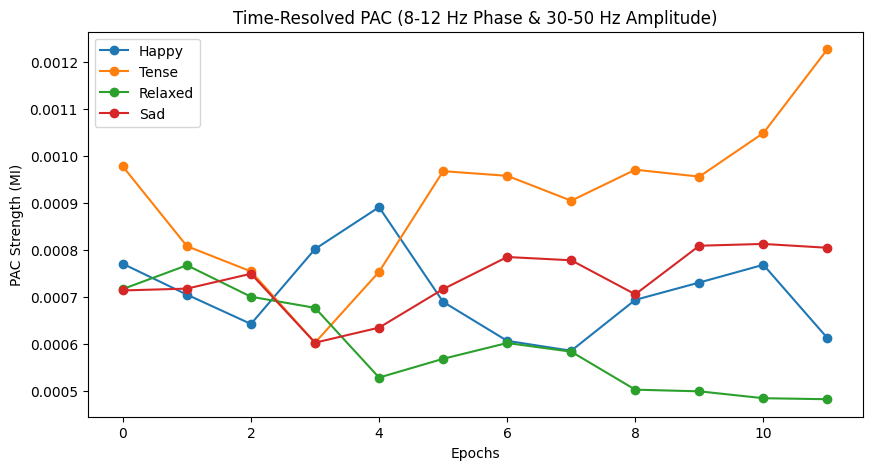

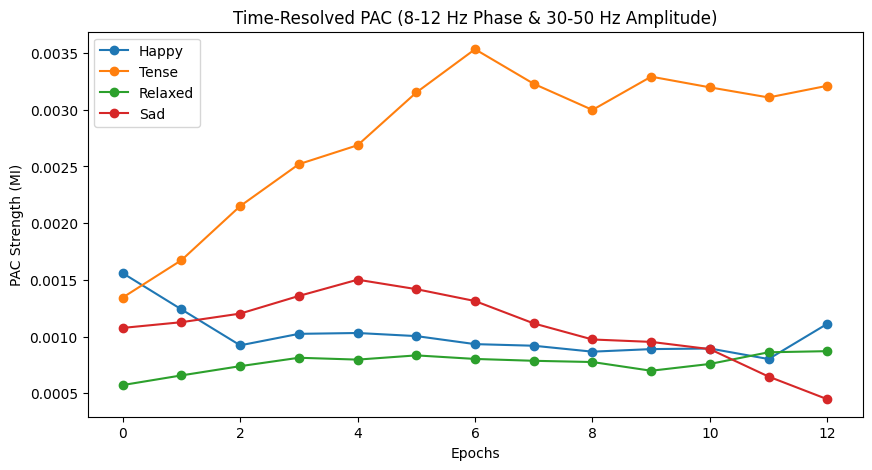

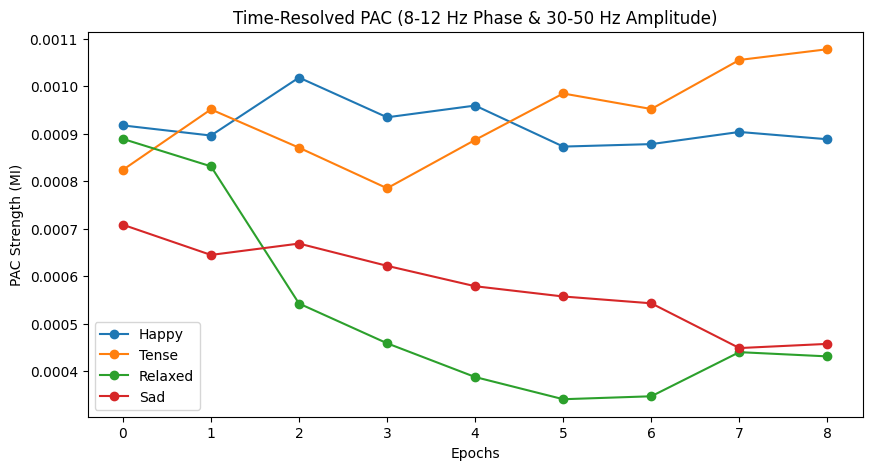

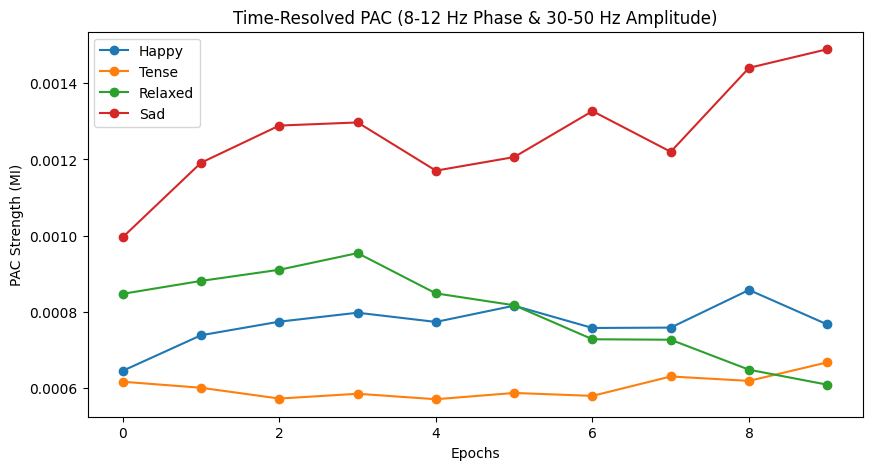

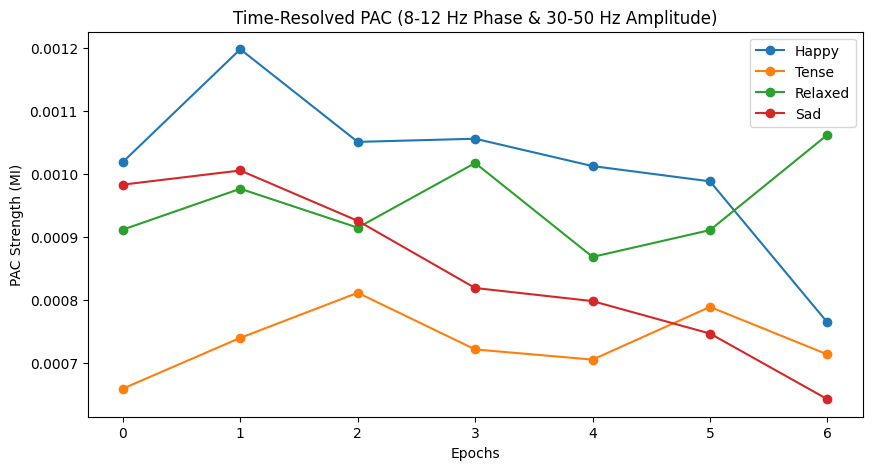

In [6389]:
# PAC analysis results stored for Alpha - Gamma

ana_pac_results = compute_time_resolved_pac(
    data=ana_data,
    fs=200,
    window_length=10, 
    freq_range_phase=(8,12),
    freq_range_amplitude=(30,50), 
)
antonio_pac_results = compute_time_resolved_pac(
    data=antonio_data,
    fs=200,
    window_length=10, 
    freq_range_phase=(8,12),
    freq_range_amplitude=(30,50), 
)
ale_pac_results = compute_time_resolved_pac(
    data=ale_data,
    fs=200,
    window_length=10, 
    freq_range_phase=(8,12),
    freq_range_amplitude=(30,50), 
)
jenny_pac_results = compute_time_resolved_pac(
    data=jenny_data,
    fs=200,
    window_length=10, 
    freq_range_phase=(8,12),
    freq_range_amplitude=(30,50), 
)
luisa_pac_results = compute_time_resolved_pac(
    data=luisa_data,
    fs=200,
    window_length=10, 
    freq_range_phase=(8,12),
    freq_range_amplitude=(30,50), 
)


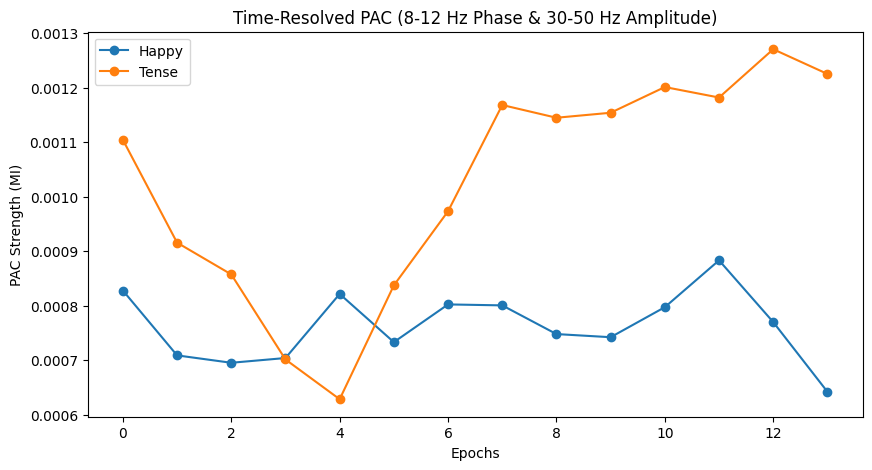

In [6377]:
# # Test PAC on Antonio and Jenny for Happy vs Tense and Happy vs Relaxed

pac_results = compute_time_resolved_pac(
    data=ana_ht,
    fs=200,
    window_length=10, 
    overlap=0.5, 
    freq_range_phase=(8,12),
    freq_range_amplitude=(30,50), 
)

In [6140]:
# Effect Sizes and P-Values for every participant
ana_stats = compute_effect_sizes(ana_pac_results,
                     name="ana")

antonio_stats = compute_effect_sizes(antonio_pac_results,
                     name="antonio")

ale_stats = compute_effect_sizes(ale_pac_results,
                     name="ale")

jenny_stats = compute_effect_sizes(jenny_pac_results,
                     name="jenny")

luisa_stats = compute_effect_sizes(luisa_pac_results,
                     name="luisa")

# Rows to look at: 0,2,3,5


Ana statistical values:
           Comparison  Cohen's d  Rank-Biserial r  Mann-Whitney p
0      Happy vs Tense    -0.4025           0.2478          0.0227
1    Happy vs Relaxed    -0.5622           0.3149          0.0038
2        Happy vs Sad    -0.7791           0.3881          0.0004
3    Happy vs Neutral    -0.6897           0.3290          0.0025
4    Tense vs Relaxed    -0.2383           0.1425          0.1905
5        Tense vs Sad    -0.5632           0.2127          0.0506
6    Tense vs Neutral    -0.4401           0.1444          0.1848
7      Relaxed vs Sad    -0.3802           0.0963          0.3767
8  Relaxed vs Neutral    -0.2364           0.0286          0.7943
9      Sad vs Neutral     0.1526          -0.0809          0.4578

Antonio statistical values:
           Comparison  Cohen's d  Rank-Biserial r  Mann-Whitney p
0      Happy vs Tense     0.1471          -0.0700          0.4286
1    Happy vs Relaxed     1.7220          -0.7769          0.0000
2        Happy vs Sad 

In [ ]:

# Function to format PAC statistics into a table 
def format_pac_results(*participant_stats, participant_names):
    """
    Formats PAC statistics for easy copying to Google Sheets, ensuring p-values are in scientific notation.
    
    Parameters:
    - *participant_stats: DataFrames containing PAC results for each participant.
    - participant_names: List of participant names.

    Returns:
    - Formatted DataFrame for easy copying.
    """
    comparisons = ["Happy vs Tense", "Happy vs Sad", "Tense vs Relaxed", "Relaxed vs Sad"]
    
    formatted_data = {"Comparison": comparisons}

    for stats_df, name in zip(participant_stats, participant_names):
        stats_df = stats_df.reset_index() 
        stats_df = stats_df[stats_df["Comparison"].isin(comparisons)]  # Keep only selected comparisons

        # Extract Cohen's d and p-values
        cohen_d = stats_df.set_index("Comparison")["Cohen's d"].to_dict()
        p_values = stats_df.set_index("Comparison")["Mann-Whitney p"].to_dict()

        # Format p-values in scientific notation
        formatted_p_values = {comp: f"{p_values[comp]:.2e}" if comp in p_values else "" for comp in comparisons}
        formatted_cohen_d = {comp: f"{cohen_d[comp]:.2f}" if comp in cohen_d else "" for comp in comparisons}

        # Add to formatted data
        formatted_data[f"{name} Cohen's d"] = [formatted_cohen_d.get(comp, "") for comp in comparisons]
        formatted_data[f"{name} p-value"] = [formatted_p_values.get(comp, "") for comp in comparisons]

    return pd.DataFrame(formatted_data)

# Implement func on participants' datasets
formatted_df = format_pac_results(jenny_stats, luisa_stats, ana_stats, ale_stats, antonio_stats, 
                                  participant_names=["Jenny", "Luisa", "Ana", "Ale", "Antonio"])

# Display the formatted DataFrame
formatted_df

# You need to flip the sign of Tense vs Relaxed when you record it as Relaxed vs Tense

,Comparison,Jenny Cohen's d,Jenny p-value,Luisa Cohen's d,Luisa p-value,Ana Cohen's d,Ana p-value,Ale Cohen's d,Ale p-value,Antonio Cohen's d,Antonio p-value
0,Happy vs Tense,-1.70,3.43e-17,0.52,2.86e-03,-0.40,2.27e-02,-0.23,7.83e-01,0.15,4.29e-01
1,Happy vs Sad,-3.86,2.31e-28,0.69,5.59e-05,-0.78,3.57e-04,-0.02,6.08e-01,2.09,5.86e-23
2,Tense vs Relaxed,0.66,1.69e-04,-0.16,9.37e-01,-0.24,1.90e-01,0.43,9.05e-02,1.40,1.81e-14
3,Relaxed vs Sad,-3.17,1.32e-27,0.34,1.72e-01,-0.38,3.77e-01,-0.27,4.17e-02,0.24,1.85e-01


# Sample Entropy

In [ ]:
# # # Create function to compute Sample Entropy
# # Sample Entropy (SampEn) measures how predictable or random the EEG signal is over time.

# # Emotional states are often linked to changes in neural complexity, where negative emotions 
# # (e.g., stress, sadness) may show higher entropy (more irregular activity) and positive emotions 
# # (e.g., relaxation, happiness) may show lower entropy (more predictable activity).

# def compute_sample_entropy(signal, m=2, r=0.2):
#     """
#     Computes Sample Entropy (SampEn) efficiently using vectorized operations.

#     Parameters:
#     - signal (array): 1D NumPy array of EEG time-series data.
#     - m (int): Embedding dimension (default = 2).
#     - r (float): Tolerance as a fraction of signal standard deviation (default = 0.2), standard treshold.

#     Returns:
#     - float: Sample Entropy value.
#     """
#     N = len(signal)
#     r *= np.std(signal)  # Convert tolerance to absolute scale

#     def _phi(m):
#         templates = np.array([signal[i:i+m] for i in range(N - m)])
#         dist_matrix = cdist(templates, templates, metric='chebyshev') # cdist() computes the Chebyshev distance (max absolute difference between elements)
#         count = np.sum(dist_matrix < r, axis=1) - 1  # Subtract 1 to exclude self-matches
#         return np.mean(count) / (N - m)

#     phi_m = _phi(m)
#     phi_m1 = _phi(m + 1)

#     if phi_m == 0 or phi_m1 == 0:
#         return np.nan  # Avoid division by zero

#     return -np.log(phi_m1 / phi_m)

# def compute_sample_entropy_all(participant_data):
#     """
#     Computes Sample Entropy (SampEn) for all participants across all emotional states.

#     Parameters:
#     - participant_data (dict): Dictionary where keys are participant names and values are
#                                dictionaries containing EEG signals for each emotional state.

#     Returns:
#     - DataFrame: Sample Entropy values for each participant and state.
#     """
#     results = []

#     for participant_name,data in participant_data.items():
#         for state, signal in data.items():
#             if len(signal) < 10:  # Ensure we have enough data points
#                 samp_entropy = np.nan
#             else:
#                 samp_entropy = compute_sample_entropy(signal)
#             results.append({"Participant": participant_name, "State": state, "Sample Entropy": samp_entropy})

#     return pd.DataFrame(results)    

# participant_data = {"Jenny":jenny_data,
#                     "Luisa":luisa_data,
#                     "Ana":ana_data,
#                     "Ale":ale_data,
#                     "Antonio":antonio_data}

# # Compute Sample Entropy for all participants
# samp_entropy_df = compute_sample_entropy_all(participant_data)

In [6143]:
# df_pivot = samp_entropy_df.pivot(index="Participant", columns="State", values="Sample Entropy").T.round(3).to_string()
# print(df_pivot)

In [ ]:
# # Sample Entropy with Time-Windowed 

# def compute_sample_entropy(signal, m=2, r=0.2):
#     """
#     Computes Sample Entropy (SampEn) efficiently using vectorized operations.

#     Parameters:
#     - signal (array): 1D NumPy array of EEG time-series data.
#     - m (int): Embedding dimension (default = 2).
#     - r (float): Tolerance as a fraction of signal standard deviation (default = 0.2).

#     Returns:
#     - float: Sample Entropy value.
#     """
#     N = len(signal)
#     r *= np.std(signal)  # Convert tolerance to absolute scale

#     def _phi(m):
#         templates = np.array([signal[i:i+m] for i in range(N - m)])
#         dist_matrix = cdist(templates, templates, metric='euclidean')  
#         count = np.sum(dist_matrix < r, axis=1) - 1  
#         return np.mean(count) / (N - m)

#     phi_m = _phi(m)
#     phi_m1 = _phi(m + 1)

#     if phi_m == 0 or phi_m1 == 0:
#         return np.nan  

#     return -np.log(phi_m1 / phi_m)

# def compute_sample_entropy_sliding(participant_data, window_size=1000, overlap=0.5):
#     """
#     Computes Sample Entropy (SampEn) for all participants across states using a sliding window.

#     Parameters:
#     - participant_data (dict): Dictionary where keys are participant names 
#                                and values are dictionaries with EEG signals for each state.
#     - window_size (int): Number of samples in each window.
#     - overlap (float): Fraction of overlap between consecutive windows.

#     Returns:
#     - DataFrame: Sample Entropy values for each participant, state, and window.
#     """
#     results = []
#     step_size = int(window_size * (1 - overlap))  

#     for participant_name, data in participant_data.items():
#         for state, signal in data.items():
#             if len(signal) < window_size:  
#                 continue  

#             # Apply sliding window
#             for start in range(0, len(signal) - window_size + 1, step_size):
#                 segment = signal[start:start + window_size]
#                 samp_en = compute_sample_entropy(segment)

#                 results.append({
#                     "Participant": participant_name,
#                     "State": state,
#                     "Window Start": start,
#                     "Window End": start + window_size,
#                     "Sample Entropy": samp_en
#                 })

#     return pd.DataFrame(results)

# # Load participant data
# participant_data = {
#     "Jenny": jenny_data,
#     "Luisa": luisa_data,
#     "Ana": ana_data,
#     "Ale": ale_data,
#     "Antonio": antonio_data
# }

# # Compute Sample Entropy using sliding windows
# samp_en_sliding_df = compute_sample_entropy_sliding(participant_data)

# # Display results
# pd.set_option("display.float_format", "{:.4f}".format)
# print(samp_en_sliding_df)

# Approximate Entropy

In [ ]:
# # # Approximate Entropy

# def approximate_entropy(signal, m=2, r=0.2):
#     """
#     Computes Approximate Entropy (ApEn) of a time-series signal.

#     Parameters:
#     - signal (array): 1D NumPy array of EEG time-series data.
#     - m (int): Embedding dimension (default = 2).
#     - r (float): Tolerance as a fraction of signal standard deviation (default = 0.2).

#     Returns:
#     - float: Approximate Entropy value.
#     """
#     N = len(signal)
#     r *= np.std(signal)  # Convert tolerance to absolute scale

#     def _phi(m):
#         templates = np.array([signal[i:i+m] for i in range(N - m)])
#         dist_matrix = cdist(templates, templates, metric='euclidean')  # Compute distances
#         count = np.sum(dist_matrix < r, axis=1) / (N - m)  # Normalize count
#         return np.mean(count)

#     phi_m = _phi(m)
#     phi_m1 = _phi(m + 1)

#     return np.log(phi_m) - np.log(phi_m1)

# def compute_approximate_entropy_all(participant_data):
#     """
#     Computes Approximate Entropy (ApEn) for all participants across emotional states.

#     Parameters:
#     - participant_data (dict): Dictionary where keys are participant names 
#                                and values are dictionaries with EEG signals for each state.

#     Returns:
#     - DataFrame: Approximate Entropy values for each participant and state.
#     """
#     results = []

#     for participant_name, data in participant_data.items():
#         for state, signal in data.items():
#             if len(signal) < 10:  # Ensure we have enough data points
#                 ap_en = np.nan
#             else:
#                 ap_en = approximate_entropy(signal)
#             results.append({"Participant": participant_name, "State": state, "Approximate Entropy": ap_en})

#     return pd.DataFrame(results)   

# participant_data = {"Jenny":jenny_data,
#                     "Luisa":luisa_data,
#                     "Ana":ana_data,
#                     "Ale":ale_data,
#                     "Antonio":antonio_data}

# # Compute Approximate Entropy for all participants
# ap_en_df = compute_approximate_entropy_all(participant_data)

# # Display the results
# #print(ap_en_df)

In [6146]:
# df_pivot_ap = ap_en_df.pivot(index="Participant", columns="State", values="Approximate Entropy").T.round(3).to_string()
# print(df_pivot_ap)

In [ ]:
# def perform_anova(ap_en_df):
#     """
#     Performs One-Way ANOVA on Approximate Entropy across emotional states.

#     Parameters:
#     - ap_en_df (DataFrame): DataFrame with 'Participant', 'State', and 'Approximate Entropy'.

#     Returns:
#     - F-statistic and p-value from ANOVA test.
#     """
#     # Ensure data is clean
#     ap_en_df = ap_en_df.dropna()  # Remove NaN values

#     # Extract Approximate Entropy values for each state
#     states = ap_en_df["State"].unique()
#     state_values = [ap_en_df[ap_en_df["State"] == state]["Approximate Entropy"].values for state in states]

#     # Perform One-Way ANOVA
#     F_statistic, p_value = f_oneway(*state_values)

#     print("\nOne-Way ANOVA Results:")
#     print(f"F-statistic: {F_statistic:.3f}")
#     print(f"p-value: {p_value:.3e}")

#     return F_statistic, p_value

# # Run ANOVA on Approximate Entropy results
# anova_results = perform_anova(ap_en_df)

In [ ]:
# Function to compute Approximate Entropy (ApEn) with a sliding window  ************
def approximate_entropy(signal, m=2, r=0.2):
    """
    Computes Approximate Entropy (ApEn) of a time-series signal.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - m (int): Embedding dimension (default = 2).
    - r (float): Tolerance as a fraction of signal standard deviation (default = 0.2).

    Returns:
    - float: Approximate Entropy value.
    """
    N = len(signal)
    r *= np.std(signal)  # Convert tolerance to absolute scale

    def _phi(m):
        templates = np.array([signal[i:i+m] for i in range(N - m)])
        dist_matrix = cdist(templates, templates, metric='euclidean')  # Compute distances
        count = np.sum(dist_matrix < r, axis=1) / (N - m)  # Normalize count
        return np.mean(count)

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    return np.log(phi_m) - np.log(phi_m1)

# Function to compute Approximate Entropy using a sliding window approach
def compute_approximate_entropy_sliding(participant_data, window_size=1000, overlap=0.5):
    """
    Computes Approximate Entropy (ApEn) for all participants across emotional states using a sliding window.

    Parameters:
    - participant_data (dict): Dictionary where keys are participant names 
                               and values are dictionaries with EEG signals for each state.
    - window_size (int): Number of samples in each window.
    - overlap (float): Fraction of overlap between consecutive windows.

    Returns:
    - DataFrame: Approximate Entropy values for each participant, state, and window.
    """
    results = []

    step_size = int(window_size * (1 - overlap))  # Compute step size based on overlap

    for participant_name, data in participant_data.items():
        for state, signal in data.items():
            if len(signal) < window_size:  # Skip if the signal is too short
                continue

            # Slide the window across the signal
            for start in range(0, len(signal) - window_size + 1, step_size):
                segment = signal[start:start + window_size]
                ap_en = approximate_entropy(segment)

                results.append({
                    "Participant": participant_name,
                    "State": state,
                    "Window Start": start,
                    "Window End": start + window_size,
                    "Approximate Entropy": ap_en
                })

    return pd.DataFrame(results)

# Load data for each participant
participant_data = {
    "Jenny": jenny_data,
    "Luisa": luisa_data,
    "Ana": ana_data,
    "Ale": ale_data,
    "Antonio": antonio_data
}

# Compute Approximate Entropy using sliding windows
ap_en_sliding_df = compute_approximate_entropy_sliding(participant_data)

# Display results
pd.set_option("display.float_format", "{:.4f}".format)
print(ap_en_sliding_df)

    Participant    State  Window Start  Window End  Approximate Entropy
0         Jenny    Happy             0        1000               1.7239
1         Jenny    Happy           500        1500               1.7304
2         Jenny    Happy          1000        2000               1.6957
3         Jenny    Happy          1500        2500               1.7023
4         Jenny    Happy          2000        3000               1.7060
..          ...      ...           ...         ...                  ...
538     Antonio  Neutral          9000       10000               1.8019
539     Antonio  Neutral          9500       10500               1.7599
540     Antonio  Neutral         10000       11000               1.6698
541     Antonio  Neutral         10500       11500               1.7896
542     Antonio  Neutral         11000       12000               1.8260

[543 rows x 5 columns]


In [ ]:
# # Function to obtain average ApEn and standard error for each state for each participant from time-windowed approach

# def compute_average_en(ap_en_sliding_df, en_type):
#     """
#     Computes the average Entropy and standard error of the mean (SEM)
#     for each state per participant.

#     Parameters:
#     - ap_en_sliding_df (DataFrame): DataFrame containing 'Participant', 'State', and 'Entropy'.
#     -en_type (str): Specific Entropy type to be selected
#     Returns:
#     - DataFrame with average ApEn values and SEM per state for each participant.
#     """
#     grouped = ap_en_sliding_df.groupby(["Participant", "State"])[f"{en_type} Entropy"]
    
#     result_df = grouped.agg(
#         Mean_ApEn="mean",
#         SEM_ApEn=lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else np.nan
#     ).reset_index()

#     return result_df

# # Compute average ApEn values with SEM
# average_ap_en_with_sem_df = compute_average_en(ap_en_sliding_df, "Approximate")

# # Display results
# # print(average_ap_en_with_sem_df)

In [ ]:
# def perform_anova_per_participant(ap_en_df):
#     """
#     Performs One-Way ANOVA on Approximate Entropy (ApEn) across emotional states for each participant.

#     Parameters:
#     - ap_en_df (DataFrame): DataFrame with 'Participant', 'State', and 'Approximate Entropy'.

#     Returns:
#     - DataFrame with ANOVA results per participant, including F-statistic and p-value.
#     """
#     results = []

#     for participant in ap_en_df["Participant"].unique():
#         subset = ap_en_df[ap_en_df["Participant"] == participant]

#         # Ensure there are multiple states with multiple values
#         grouped = [state_group["Approximate Entropy"].dropna().values for _, state_group in subset.groupby("State")]

#         if len(grouped) > 1 and all(len(g) > 1 for g in grouped):
#             F_stat, p_value = stats.f_oneway(*grouped)  # Compare across states
#             p_value = f"{p_value:.2e}"  # Convert p-value to scientific notation
#         else:
#             F_stat, p_value = None, None  # Not enough valid data points

#         results.append({"Participant": participant, "F-statistic": F_stat, "p-value": p_value})

#     return pd.DataFrame(results)

# # Run ANOVA across states for each participant
# rm_anova_results_per_participant = perform_anova_per_participant(ap_en_sliding_df)

# # Display results
# print(rm_anova_results_per_participant)

In [ ]:

# def perform_pairwise_tests(ap_en_df):
#     """
#     Performs pairwise t-tests for Approximate Entropy (ApEn) between all states per participant.

#     Parameters:
#     - ap_en_df (DataFrame): DataFrame with 'Participant', 'State', and 'Approximate Entropy'.

#     Returns:
#     - DataFrame with pairwise t-test results (p-values), adjusted with Bonferroni correction.
#     """
#     results = []

#     for participant in ap_en_df["Participant"].unique():
#         subset = ap_en_df[ap_en_df["Participant"] == participant]

#         # Generate all pairwise comparisons
#         state_pairs = list(itertools.combinations(subset["State"].unique(), 2))
#         p_values = []

#         for state1, state2 in state_pairs:
#             data1 = subset[subset["State"] == state1]["Approximate Entropy"].dropna()
#             data2 = subset[subset["State"] == state2]["Approximate Entropy"].dropna()

#             if len(data1) > 1 and len(data2) > 1:
#                 t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
#                 p_values.append(p_value)
#                 results.append({"Participant": participant, "Comparison": f"{state1} vs {state2}", "p-value": f"{p_value:.2e}"})
#             else:
#                 p_values.append(None)

#         # Apply Bonferroni correction for multiple comparisons
#         corrected_p_values = multipletests([p for p in p_values if p is not None], method="bonferroni")[1]

#         # Update corrected p-values in results
#         corrected_index = 0
#         for res in results:
#             if res["Participant"] == participant and res["p-value"] is not None:
#                 res["Corrected p-value"] = corrected_p_values[corrected_index]
#                 corrected_index += 1

#     return pd.DataFrame(results)

# # Run pairwise tests
# pairwise_results_df = perform_pairwise_tests(ap_en_sliding_df)

# # Display results
# print(pairwise_results_df)

In [6152]:
# def plot_pairwise_p_values(pairwise_df):
#     """
#     Plots a heatmap of corrected p-values for pairwise state comparisons per participant.

#     Parameters:
#     - pairwise_df (DataFrame): DataFrame containing 'Participant', 'Comparison', and 'Corrected p-value'.

#     Returns:
#     - Displays heatmap.
#     """
#     # Pivot the data for heatmap format
#     heatmap_data = pairwise_df.pivot(index="Participant", columns="Comparison", values="Corrected p-value")

#     plt.figure(figsize=(12, 6))
#     ax = sns.heatmap(heatmap_data, annot=True, fmt=".2e", cmap="coolwarm", cbar=True, linewidths=0.5)

#     plt.title("Corrected p-values for Pairwise Approximate Entropy Comparisons")

#     # Remove x and y axis labels
#     ax.set_xlabel("")
#     ax.set_ylabel("")

#     plt.xticks(rotation=45, ha='right')
#     plt.show()

# # Run the visualization
# plot_pairwise_p_values(pairwise_results_df)

# Multi-Scale Entropy (MSE) Using SampEn

Jenny Results:


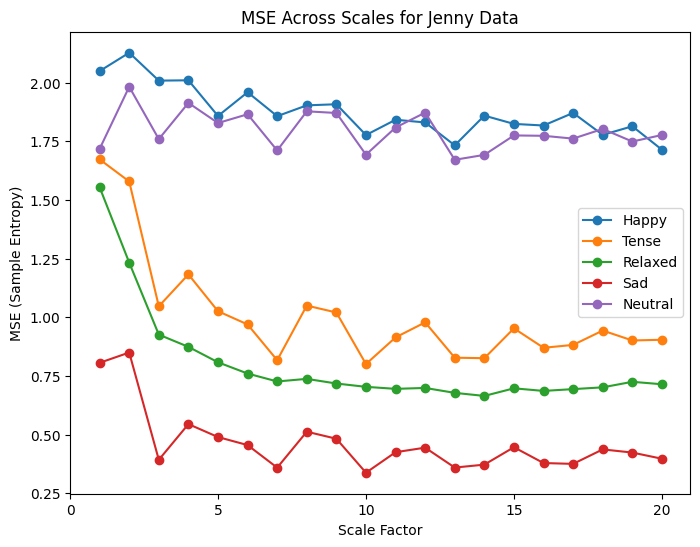

In [ ]:
def compute_sampen_single(signal, m=2, r=0.2):
    """
    Computes Sample Entropy (SampEn) for a single coarse-grained signal.
    
    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - m (int): Embedding dimension.
    - r (float): Tolerance as a fraction of signal standard deviation.

    Returns:
    - float: Sample Entropy value.
    """
    N = len(signal)
    if N < m + 1:  # Ensure the signal is long enough
        return np.nan
    r *= np.std(signal)  # Convert tolerance to absolute scale

    def _phi(m):
        templates = np.lib.stride_tricks.sliding_window_view(signal, window_shape=m)
        if templates.shape[0] < 2:
            return np.nan  # Avoid issues with very short segments
        dist_matrix = cdist(templates, templates, metric='chebyshev')
        count = np.sum(dist_matrix < r, axis=1) - 1  # Exclude self matches
        return np.mean(count) / (N - m)

    phi_m = _phi(m)
    phi_m1 = _phi(m + 1)

    if np.isnan(phi_m) or np.isnan(phi_m1) or phi_m1 == 0:
        return np.nan  # Avoid division errors

    return -np.log(phi_m1 / phi_m)

def compute_mse(signal, max_scale=20):
    """
    Computes Multiscale Entropy (MSE) efficiently using SampEn across multiple scales.

    Parameters:
    - signal (array): 1D NumPy array of EEG time-series data.
    - max_scale (int): Maximum scale factor for coarse-graining.

    Returns:
    - Dict containing SampEn values at each scale.
    """
    mse_results = {}

    for scale in range(1, max_scale + 1):
        if len(signal) < scale:
            mse_results[f"Scale {scale}"] = np.nan  # Skip if scale is too large
            continue
        coarse_signal = np.mean(signal[:len(signal) - len(signal) % scale].reshape(-1, scale), axis=1)
        
        if len(coarse_signal) > 10:  # Ensure enough data points
            mse_results[f"Scale {scale}"] = compute_sampen_single(coarse_signal)
        else:
            mse_results[f"Scale {scale}"] = np.nan  # Not enough data for computation

    return mse_results

def compute_mse_all(data, max_scale=20):
    """
    Computes Multiscale Entropy (MSE) for EEG signals across different conditions.

    Parameters:
    - data (dict): Dictionary where keys are conditions (e.g., horror, vipassana, hot tub)
                   and values are NumPy arrays of EEG signals.
    - max_scale (int): Maximum scale factor for coarse-graining.

    Returns:
    - DataFrame: MSE values for each condition and scale.
    """
    results = []

    for condition, signal in data.items():  # Iterate through conditions
        mse_values = compute_mse(signal, max_scale)
        
        for scale, mse_value in mse_values.items():
            results.append({
                "Condition": condition,
                "Scale": int(scale.split(" ")[1]),  # Convert "Scale X" to integer X
                "MSE": mse_value
            })

    return pd.DataFrame(results)

def plot_mse_per_state(mse_df, name):
    """
    Plots MSE trends across scale factors for each condition.

    Parameters:
    - mse_df (DataFrame): DataFrame containing 'Condition', 'Scale', and 'MSE'.
    """
    unique_conditions = mse_df["Condition"].unique()

    fig, ax = plt.subplots(figsize=(8,6))
    
    for condition in unique_conditions:
        subset = mse_df[mse_df["Condition"] == condition]

        ax.plot(subset["Scale"], subset["MSE"], marker="o", label=condition)
    ax.set(xlabel="Scale Factor", ylabel="MSE (Sample Entropy)", title=f"MSE Across Scales for {name} Data")
    ax.set(xticks=np.arange(0,21,5))
    ax.legend()

    plt.show()

# Compute MSE on UCSF dataset
mse_jenny_df = compute_mse_all(jenny_data, max_scale=20)

print("Jenny Results:")

# Plot results
plot_mse_per_state(mse_jenny_df,name="Jenny")



Luisa Results:


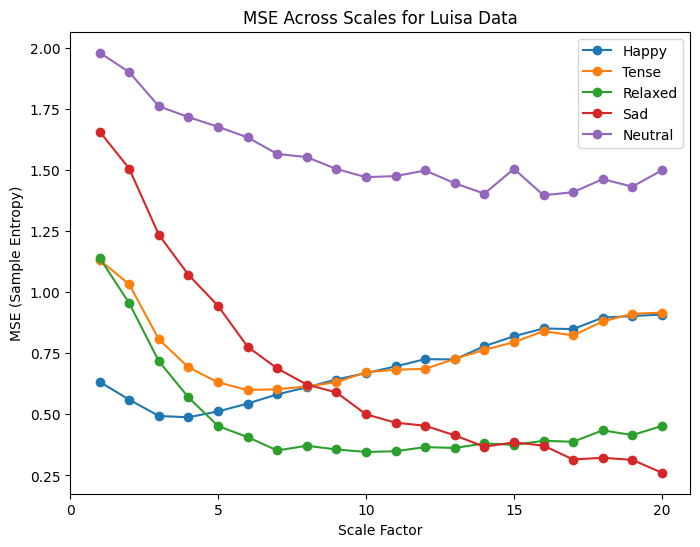

In [6154]:
# Compute MSE on UCSF dataset
mse_luisa_df = compute_mse_all(luisa_data, max_scale=20)

print("Luisa Results:")

# Plot results
plot_mse_per_state(mse_luisa_df,name="Luisa")

Ana Results:


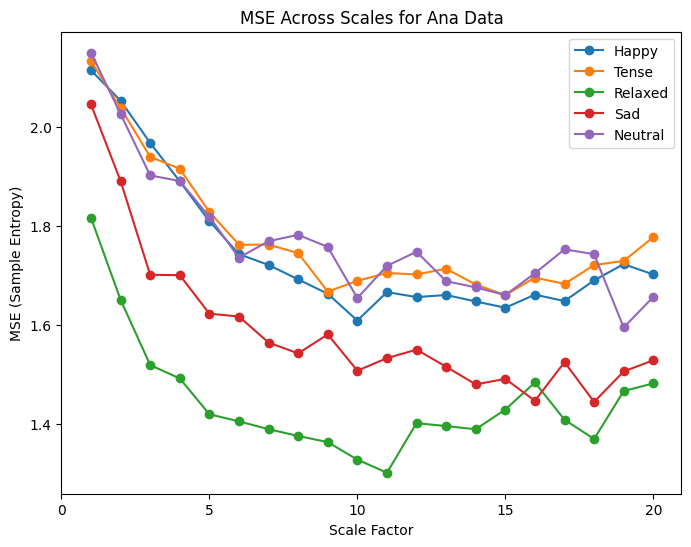

In [6155]:
# Compute MSE on UCSF dataset
mse_ana_df = compute_mse_all(ana_data, max_scale=20)

print("Ana Results:")

# Plot results
plot_mse_per_state(mse_ana_df,name="Ana")

Ale Results:


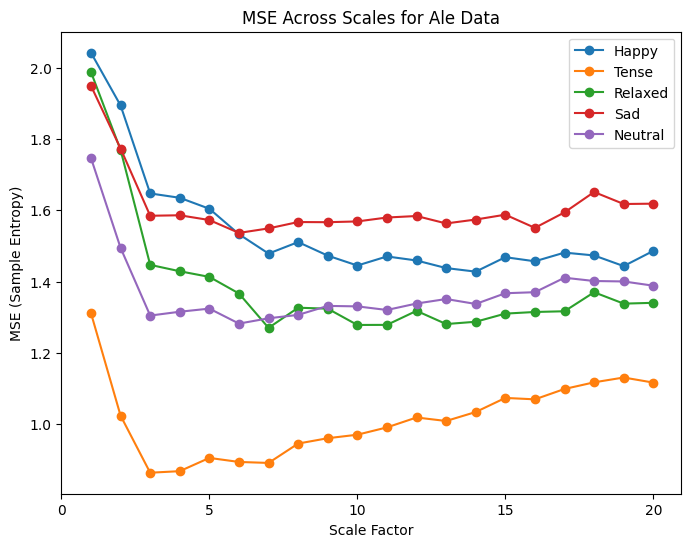

In [6378]:
# Compute MSE on UCSF dataset
mse_ale_df = compute_mse_all(ale_data, max_scale=20)

print("Ale Results:")

# Plot results
plot_mse_per_state(mse_ale_df, name="Ale")

Antonio Results:


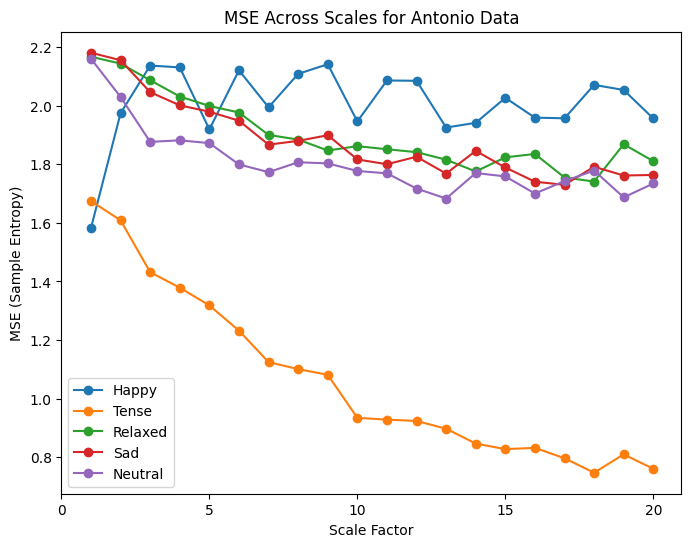

In [6157]:
# Compute MSE on UCSF dataset
mse_antonio_df = compute_mse_all(antonio_data, max_scale=20)

print("Antonio Results:")

# Plot results
plot_mse_per_state(mse_antonio_df,name="Antonio")

# Appendix

In [6158]:
# def compute_power_phase(filtered_data):
#     power_phase_data = {}
#     for state,data in filtered_data.items():
#         analytic_signal = signal.hilbert(data)
#         signal_power, signal_phase = abs(analytic_signal)**2, np.angle(analytic_signal)
#         power_phase_data[state] = [signal_power,signal_phase]
        
#     return power_phase_data


##################################################################################################################

# # Representation of results for all participants (MANUAL ENTRY)

# # Data for each participant
# participants = ["Jenny", "Luisa", "Ana", "Ale", "Antonio"]
# comparisons = ["Happy vs. Tense", "Happy vs. Sad", "Relaxed vs. Tense", "Relaxed vs. Sad"]

# # Effect sizes, p-values, and significance (Manually input from previous results)
# data = {
#     "Jenny": [(-2.05, 1.52e-22), (-4.46, 2.38e-32), (0.34, 1.78e-09), (-1.99, 5.67e-22)],
#     "Luisa": [(0.08, 5.41e-01), (-1.65, 1.38e-09), (-1.63, 1.25e-08), (0.32, 8.76e-02)],
#     "Ana": [(-1.05, 1.75e-11), (-0.42, 4.58e-02), (0.83, 1.45e-06), (-0.33, 1.18e-01)],
#     "Ale": [(0.87, 8.97e-09), (1.11, 6.20e-11), (0.19, 2.68e-01), (0.02, 5.82e-01)],
#     "Antonio": [(-0.13, 4.23e-01), (1.17, 2.89e-11), (1.29, 7.92e-14), (-0.14, 4.44e-01)]
# }

# # Convert to DataFrame
# df = pd.DataFrame(data, index=comparisons)

# # Format table with effect size, p-value, and significance label
# formatted_df = df.map(lambda x: f"d={x[0]:.2f}, p={x[1]:.2e}")
# print(formatted_df)

##################################################################################################################

# # Heatmap representation of data (not pooled)
# Data setup
# participants = ["Jenny", "Luisa", "Ana", "Ale", "Antonio"]
# comparisons = ["Happy vs. Tense", "Happy vs. Sad", "Relaxed vs. Tense", "Relaxed vs. Sad"]

# data = {
#     "Jenny": [(-2.05, 1.52e-22), (-4.46, 2.38e-32), (-0.34, 1.78e-09), (-1.99, 5.67e-22)],
#     "Luisa": [(0.08, 5.41e-01), (-1.65, 1.38e-09), (1.63, 1.25e-08), (0.32, 8.76e-02)],
#     "Ana": [(-1.05, 1.75e-11), (-0.42, 4.58e-02), (-0.83, 1.45e-06), (-0.33, 1.18e-01)],
#     "Ale": [(0.87, 8.97e-09), (1.11, 6.20e-11), (-0.19, 2.68e-01), (0.02, 5.82e-01)],
#     "Antonio": [(-0.13, 4.23e-01), (1.17, 2.89e-11), (-1.29, 7.92e-14), (-0.14, 4.44e-01)]
# }

# df = pd.DataFrame(data, index=comparisons)

# # Extract Cohen's d and p-values separately
# effect_sizes = df.map(lambda x: x[0])
# p_values = df.map(lambda x: x[1])

# # Create heatmap
# plt.figure(figsize=(10, 6))
# cmap = sns.diverging_palette(240, 10, as_cmap=True)  # Blue for negative, Red for positive
# ax = sns.heatmap(effect_sizes, annot=False, cmap=cmap, center=0, linewidths=0.5, vmin=-2.5, vmax=2.5)

# # Annotate each cell with Cohen's d and p-value
# for i in range(effect_sizes.shape[0]):
#     for j in range(effect_sizes.shape[1]):
#         d_val = effect_sizes.iloc[i, j]
#         p_val = p_values.iloc[i, j]
#         text = f"d={d_val:.2f}\n p={p_val:.2e}"
#         ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', fontsize=10, color='black')

# # Labels and formatting
# plt.xticks(ticks=np.arange(len(participants)) + 0.5, labels=participants, rotation=45, ha="right")
# plt.yticks(ticks=np.arange(len(comparisons)) + 0.5, labels=comparisons, rotation=0)
# plt.xlabel("Participants")
# plt.title("Effect Sizes and P-Values for PAC (Delta-Gamma) Comparing Valence Across Participants")

# # Color bar label
# cbar = ax.collections[0].colorbar
# cbar.set_label("Cohen's d")

# # Show plot
# plt.show()


##################################################################################################################

# # Pooling participant data together ****

# Function to extract relevant comparisons and pool them
# def extract_pac_data(*participant_stats, comparisons):
#     """
#     Extracts Cohen's d and p-values for pooling.

#     Parameters:
#     - *participant_stats: DataFrames containing PAC results for individual participants.
#     - comparisons: List of state comparisons to include.

#     Returns:
#     - Dictionary with effect sizes and p-values for each comparison.
#     """
#     pooled_data = {comp: {"effect_sizes": [], "p_values": []} for comp in comparisons}

#     for stats_df in participant_stats:
#         stats_df = stats_df.reset_index()  # Ensure 'Comparison' is a column

#         for comp in comparisons:
#             if comp not in stats_df["Comparison"].values:
#                 print(f"⚠️ Warning: {comp} not found in a participant's data!")
#                 continue

#             filtered_row = stats_df[stats_df["Comparison"] == comp]
#             if not filtered_row.empty:
#                 effect_size = filtered_row["Cohen's d"].values[0]
#                 p_value = filtered_row["Mann-Whitney p"].values[0]

#                 pooled_data[comp]["effect_sizes"].append(effect_size)
#                 pooled_data[comp]["p_values"].append(p_value)

#     return pooled_data


# # Function to compute pooled statistical tests
# def compute_pooled_statistics(pooled_data):
#     """
#     Computes pooled Cohen’s d using sample-size weighting and applies Fisher’s Method for p-values.

#     Parameters:
#     - pooled_data: Dictionary containing pooled PAC effect sizes and p-values.

#     Returns:
#     - DataFrame summarizing pooled effect sizes, p-values, and significance levels.
#     """
#     results = []

#     for comp, values in pooled_data.items():
#         effect_sizes = np.array(values["effect_sizes"])
#         p_values = np.array(values["p_values"])

#         # Ensure no missing values
#         if len(effect_sizes) == 0 or len(p_values) == 0:
#             print(f"⚠️ Warning: No valid data found for {comp}!")
#             continue  # Skip this comparison if no data

#         # **Step 1: Compute Weighted Cohen's d**
#         sample_sizes = np.full_like(effect_sizes, 100)  # Assuming equal sample sizes
#         weighted_d = np.sum(effect_sizes * sample_sizes) / np.sum(sample_sizes)  # Weighted avg

#         # **Step 2: Compute Pooled Standard Deviation**
#         pooled_variance = np.sum((effect_sizes - weighted_d) ** 2) / len(effect_sizes)
#         std_effect_size = np.sqrt(pooled_variance)

#         # **Step 3: Apply Fisher’s Method for p-values**
#         p_values = np.where(p_values == 0, 1e-10, p_values)  # Prevent log(0)
#         chi2_stat = -2 * np.sum(np.log(p_values))
#         df = 2 * len(p_values)
#         pooled_p_value = stats.chi2.sf(chi2_stat, df)

#         # Determine significance level
#         if pooled_p_value < 0.001:
#             significance = "***"
#         elif pooled_p_value < 0.01:
#             significance = "**"
#         elif pooled_p_value < 0.05:
#             significance = "*"
#         else:
#             significance = ""

#         results.append({
#             "Comparison": comp,
#             "Pooled Cohen's d": weighted_d,
#             "Pooled Std Dev": std_effect_size,
#             "Pooled p-value": pooled_p_value,
#             "Significance": significance
#         })

#     return pd.DataFrame(results)

# # Define the comparisons to pool
# comparisons = ["Happy vs Tense", "Happy vs Sad", "Tense vs Relaxed", "Relaxed vs Sad"]

# # Extract PAC data
# pooled_pac_data = extract_pac_data( antonio_stats, jenny_stats,  comparisons=comparisons)

# # Compute final pooled statistics
# pooled_results_df = compute_pooled_statistics(pooled_pac_data)

# # Display results
# print(pooled_results_df)

##################################################################################################################

# # Summarized PAC Values

# def summarize_pac_statistics(pooled_data):
#     """
#     Summarizes effect sizes per participant and applies Fisher’s Method for pooled p-values.

#     Parameters:
#     - pooled_data: Dictionary containing Cohen’s d and p-values for each comparison.

#     Returns:
#     - DataFrame summarizing individual and pooled statistical results.
#     """
#     results = []

#     for comp, values in pooled_data.items():
#         effect_sizes = np.array(values["effect_sizes"])
#         p_values = np.array(values["p_values"])

#         # Ensure no missing values
#         if len(effect_sizes) == 0 or len(p_values) == 0:
#             print(f"⚠️ Warning: No valid data found for {comp}!")
#             continue  

#         # **Fisher’s Method for p-values**
#         p_values = np.where(p_values == 0, 1e-10, p_values)  # Prevent log(0)
#         chi2_stat = -2 * np.sum(np.log(p_values))
#         df = 2 * len(p_values)
#         pooled_p_value = stats.chi2.sf(chi2_stat, df)

#         # Determine significance level
#         if pooled_p_value < 0.001:
#             significance = "***"
#         elif pooled_p_value < 0.01:
#             significance = "**"
#         elif pooled_p_value < 0.05:
#             significance = "*"
#         else:
#             significance = ""

#         # Store individual effect sizes
#         result_entry = {
#             "Comparison": comp,
#             "Pooled p-value": pooled_p_value,
#             "Significance": significance
#         }
        
#         # Add each participant's effect size
#         for i, es in enumerate(effect_sizes):
#             result_entry[f"Participant {i+1} Cohen's d"] = es

#         results.append(result_entry)

#     return pd.DataFrame(results)

# print(summarize_pac_statistics(pooled_pac_data))

###################################################################################################




